In [1]:
%load_ext autoreload
%autoreload 2
import sys,os,importlib,gc,string
import xarray as xr
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import statsmodels.api as sm

os.chdir('/home/peterp/projects/tc_emulator/results')

sys.path.append('../git_tc_emulator')
import _weather_pattern_class; importlib.reload(_weather_pattern_class)

<module '_weather_pattern_class' from '/home/peterp/projects/tc_emulator/git_tc_emulator/_weather_pattern_class.py'>

In [2]:
atl = _weather_pattern_class.weather_patterns(source='ERA5', working_directory='./')
atl.load_input('ERA5_VWS-MSLP_noTC3')
years = np.array(range(1982,2021))
atl.set_split(years=years)
nrows,ncols = 5,4
tag = 'SOM_pcaInit%sx%s_v1' % (nrows,ncols)
atl.define_plot_environment(pre_mapping='mapping_raw', clustering=tag, post_mapping='mapping_sammon_1982-2020', nrows=nrows, ncols=ncols)
atl.stats_TC(file='tracks/tracks_ibtracks.csv', overwrite=False)

{'SOM': <minisom.MiniSom object at 0x7fdfcca14be0>}
.//ERA5_VWS-MSLP_noTC3/mapping_raw_1982-2020/SOM_pcaInit5x4_v1 mapping_sammon_1982-2020
.//ERA5_VWS-MSLP_noTC3/mapping_raw_1982-2020/SOM_pcaInit5x4_v1 mapping_sammon_1982-2020
.//ERA5_VWS-MSLP_noTC3/mapping_raw_1982-2020/SOM_pcaInit5x4_v1/mapping_sammon_1982-2020/grid_5x4


In [3]:
atl.stats_frequency()

## Counterfactuals

In [4]:
# HadISST
sst_hist = xr.open_dataset('/home/peterp/projects/data/SST/HadISST_sst.nc')['sst'].loc[:,20:10,-90:-20]
lat_weight = np.cos(np.deg2rad(sst_hist.latitude.values))
lat_weight_array = np.repeat(lat_weight[np.newaxis,:], sst_hist.shape[2], 0).T
valid = np.isfinite(sst_hist[0,:,:].values)
sst_hist = xr.DataArray(np.nansum(sst_hist * lat_weight_array, axis=(1,2)) / np.sum(lat_weight_array[valid]), coords={'time':sst_hist.time}, dims=['time'])
hadisst_MDR = sst_hist[np.isin(sst_hist.time.dt.month,[8,9,10])].groupby('time.year').mean('time').loc[:2020]

# yearly SSTS for OISST
tmp = xr.load_dataset('/home/peterp/projects/data/SST/OISST_sst_MDR_daily_all.nc')['sst']
oisst_MDR = tmp.loc[np.isin(tmp.time.dt.month,[8,9,10])].groupby('time.year').mean('time')

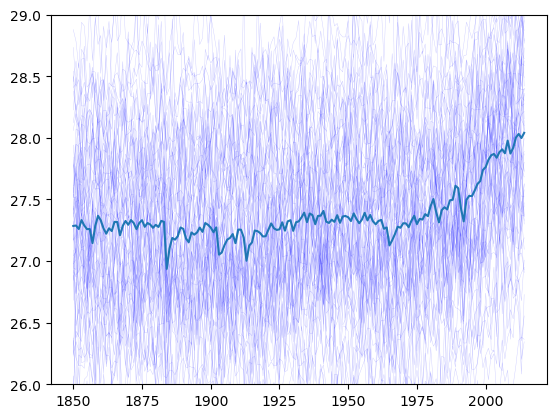

In [5]:
# CMIP6
%matplotlib inline
sst_cmip6 = xr.open_dataset('SST_MDR_ASO_CMIP6.nc')['sst']
cmip6_MDR = sst_cmip6.mean('model').compute()

for mod in sst_cmip6.model.values:
    plt.plot(sst_cmip6.year, sst_cmip6.loc[mod,:], color='b', alpha=0.2, linewidth=0.3)
plt.plot(sst_cmip6.year,cmip6_MDR, label='CMIP6 median')   
plt.ylim(26,29)
plt.show()

In [6]:
lr_cmip6 = sm.OLS(cmip6_MDR.loc[1982:].values, sm.add_constant(sst_cmip6.loc[:,1982:].year.values)).fit().params
lr_hadisst = sm.OLS(hadisst_MDR.loc[1982:].values, sm.add_constant(hadisst_MDR.loc[1982:].year.values)).fit().params
lr_oisst = sm.OLS(oisst_MDR.loc[1982:].values, sm.add_constant(oisst_MDR.loc[1982:].year.values)).fit().params

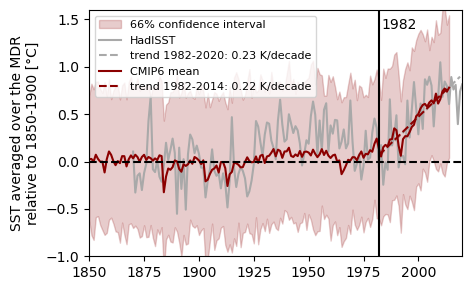

In [7]:
plt.close()
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(5,3), dpi=100)
bounds = np.nanpercentile((sst_cmip6 - cmip6_MDR.loc[1850:1900].mean()).rolling(year=1, center=True).mean(),[17,83],axis=0).squeeze()
ax.fill_between(sst_cmip6.year, bounds[0,:], bounds[1,:], 
                 alpha=0.2, color='darkred', label='66% confidence interval', zorder=0)

for sst_raw,lr,color,label in zip([cmip6_MDR,hadisst_MDR][::-1],[lr_cmip6,lr_hadisst][::-1],
                              ['darkred','darkgray'][::-1],['CMIP6 mean','HadISST'][::-1]):
    
    shift = sst_raw.loc[1850:1900].mean().values
    sst = sst_raw - shift
    
    ax.plot(sst.year,sst,color=color, label=label,zorder=1)
    
    ax.plot(range(1982,sst.year.values[-1]), lr[0] - shift + lr[1] * range(1982,sst.year.values[-1]), color=color, linestyle='--',
             label='trend 1982-%s: %s K/decade' %(sst.year.values[-1],round(lr[1]*10,2)),zorder=1)
    # ax.plot([1982],[lr[0] + lr[1]*1982], marker='*', markerfacecolor=color, markeredgecolor='k', markersize=15,
    #              label='trend in 1982: %s K' %(np.round(lr[0] + lr[1]*1982,2)), linestyle='', zorder=10)

ax.axhline(y=0, color='k', linestyle='--')
ax.axvline(x=1982, color='k')
ax.annotate('1982', xy=(1983,1.4))
ax.set_ylabel('SST averaged over the MDR\nrelative to 1850-1900 [°C]')
ax.set_ylim(-1,1.6)
ax.legend(loc='upper left', fontsize=8)
ax.set_xlim(1850,2020)
plt.tight_layout()

In [8]:
y_story = 2005
y_now = 2024

In [9]:
detrend = oisst_MDR - (lr_cmip6[1] * oisst_MDR.year + lr_cmip6[0])
lr_detrend = sm.OLS(detrend.loc[1982:2020].values, sm.add_constant(detrend.loc[1982:2020].year.values)).fit().params

sst_counterfacts = {'ref':oisst_MDR}
cou = detrend + lr_cmip6[0] + lr_cmip6[1] * y_now
sst_counterfacts[y_now] = cou
cou = detrend + lr_cmip6[0] + lr_cmip6[1] * 1982
sst_counterfacts['1982'] = cou
cou = detrend + lr_cmip6[0] + lr_cmip6[1] * y_story
sst_counterfacts[y_story] = cou

In [10]:
lr_cmip6[1]

0.022498346140200465

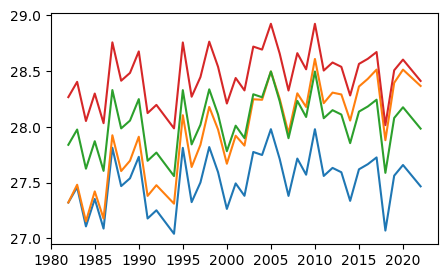

In [11]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(5,3), dpi=100)
for scenario in ['1982', 'ref',y_story,y_now]:
    ax.plot(sst_counterfacts[scenario].year, sst_counterfacts[scenario])

In [12]:
train_folder = 'ERA5_VWS-MSLP_noTC3/mapping_raw_1982-2020/SOM_pcaInit5x4_v1/mapping_sammon_1982-2020/grid_5x4/emulator/2001-2010/'

In [13]:
# choose components
alphabet = iter(list(string.ascii_lowercase))
dt = {'g':'gWeaLag2Weight', 'sL':'sLWeaNeigh', 'wS':'wS100nnQrSST', 'Emu':'Emu0', 'name':'main','l':next(alphabet),'c':'c'}
N = 1000
years = range(1982,2021)
overwrite = False

tag = '_'.join([dt[k] for k in ['g','sL','wS','Emu']])
print(tag)
import _emulator; importlib.reload(_emulator); from _emulator import *
for k,v in {k:v for k,v in dt.items() if k in ['g','sL','wS','Emu']}.items():
    exec(f"from {'components.'+k+'.'+v} import *")
genesis_obj = pickle.load(open(train_folder+'/_comp_g_'+dt['g']+'/genesis_obj.pkl', 'rb'))
end_obj = pickle.load(open(train_folder+'/_comp_sL_'+dt['sL']+'/end_obj.pkl', 'rb'))
wind_obj = pickle.load(open(train_folder+'/_comp_wS_'+dt['wS']+'/wind_obj.pkl', 'rb'))
emu = storm_emulator(dir=train_folder, tag=tag, emulate_season_function=emulate_season_function)

gWeaLag2Weight_sLWeaNeigh_wS100nnQrSST_Emu0


In [14]:
years = np.array([y_story, y_now])
# get sst
sst_MDR_old = xr.load_dataset('/home/peterp/projects/data/SST/OISST_sst_MDR_daily_all.nc')['sst']
sst_MDR_newer = xr.open_mfdataset('/home/peterp/projects/data/SST/OISST/sst_*202*.nc')['sst']
sst_MDR = xr.concat([sst_MDR_old, sst_MDR_newer], dim='time')
sst_MDR = sst_MDR[np.isin(sst_MDR.time.dt.year,years)]
sst_MDR = sst_MDR[np.isin(sst_MDR.time.dt.month,atl._months['mon'])]
sst_MDR = sst_MDR.assign_coords(time=np.array([str(d)[:10] for d in sst_MDR.time.values], np.datetime64))

In [15]:
years = np.array([y_story])
# prepare gensis input
# this is a dataframe with an entry for each day
# this is required to get genesis probabilities
weather_sst = pd.DataFrame()
weather_sst['time'] =  np.array([str(d)[:10] for d in  atl._vector_time.values], np.datetime64)
weather_sst['year'] = atl._vector_time.dt.year
weather_sst['weather_0'] = atl._clust_labels
weather_sst['weather_1'] = np.roll(atl._clust_labels,1)
weather_sst['weather_2'] = np.roll(atl._clust_labels,2)
weather_sst['weather_3'] = np.roll(atl._clust_labels,3)
weather_sst = weather_sst.loc[np.isin(atl._vector_time.dt.year,years)]

weather_sst['sst'] = sst_MDR.sel(time=weather_sst.time.values)

weather_sst['day_in_season'] = 0
for year in np.unique(weather_sst.time.dt.year):
    tttmmmppp = weather_sst.loc[(weather_sst.time.dt.year==year),'day_in_season']
    weather_sst.loc[(weather_sst.time.dt.year==year),'day_in_season'] = np.arange(tttmmmppp.shape[0])

weather_sst = weather_sst.loc[(weather_sst.day_in_season>=3) & np.isin(weather_sst.year,years)]

emu._weather_sst = weather_sst

In [16]:
sst_counterfacts.keys()

dict_keys(['ref', 2024, '1982', 2005])

In [17]:
scenario

2024

In [18]:
counterFacts = {}
for scenario in [y_story,'1982',y_now]:
    if scenario == '1982' or True:
        sst_diff_counterfactual = (sst_counterfacts[scenario].loc[year] - sst_counterfacts['ref'].loc[year]).values    
    else:
        sst_diff_counterfactual = 0
    print(scenario,year,sst_diff_counterfactual)
    emu.simulate_sst_counterfactual(name='_%s_shift%s' %(year,scenario), years=[year], sst_shift=sst_diff_counterfactual, N=N, genesis_obj=genesis_obj, wind_obj=wind_obj, end_obj=end_obj, overwrite=overwrite)
    
    counterFacts['%s SST levels' %(scenario)] = emu._simu

2005 2005 0.0
1982 2005 -0.5174619612246119
2024 2005 0.4274685766638129


In [19]:
now = xr.open_dataset(f'/home/peterp/projects/data/SST/OISST/sst_mdr_{y_now}.nc')['sst']
story = xr.open_dataset(f'/home/peterp/projects/data/SST/OISST/sst_mdr_{y_story}.nc')['sst']
sst_diff_story = np.mean(now.values - story[:len(now)].values)
print(f"{str(now.time.values[0])[5:10]} to {str(now.time.values[-1])[5:10]}")
print(f"sst diff between {y_now} and {y_story}: {sst_diff_story}")

05-01 to 06-26
sst diff between 2024 and 2005: 0.5377865433692932


In [20]:
emu.simulate_sst_counterfactual(name='_%s_shift%s' %(y_story,'story_2024'), years=[y_story], sst_shift=sst_diff_story, N=N, genesis_obj=genesis_obj, wind_obj=wind_obj, end_obj=end_obj, overwrite=overwrite)
counterFacts[f'{y_now} SST story'] = emu._simu

## correct for missing months

In [21]:
tcs = pd.read_csv('/home/peterp/projects/data/ibtracs.NA.list.v04r00.csv', sep=',', low_memory=False)
units = tcs.iloc[0]
tcs = tcs.drop([0])
tcs["ISO_TIME"] = pd.to_datetime(tcs["ISO_TIME"]) 
notna1 = (tcs['ISO_TIME'].dt.year >= 1979) & (tcs['ISO_TIME'].dt.year <= 2020)
tcs["WMO_WIND"] = tcs["WMO_WIND"].replace(' ',np.nan)
tcs["WMO_WIND"] = pd.to_numeric(tcs["WMO_WIND"]) 
notna2 = np.isfinite(tcs['WMO_WIND'].values) & (tcs['WMO_WIND'] > 0)
notna3 = tcs['NATURE'] == 'TS'
notna = notna1 & notna2 & notna3
tcs = tcs[notna].reset_index()
ace = tcs['WMO_WIND'].values.copy()
ace[ace < 34] = 0
ace = ace ** 2 / 10000
tcs['ACE'] = ace
# tcs.head()
climatology = tcs.groupby(tcs['ISO_TIME'].dt.month)['ACE'].sum() / np.unique(tcs['ISO_TIME'].dt.year).shape[0]
print(climatology)
print('ACE in June+July+November ',climatology.loc[[6,7,11]].values.sum())
print('ACE in ASO ',climatology.loc[[8,9,10]].values.sum())
fraction_of_ace_outside_of_season = climatology.loc[[6,7,11]].values.sum() \
      / climatology.loc[[6,7,8,9,10,11]].values.sum()
print('fraction of ACE in June+July+November', fraction_of_ace_outside_of_season)

ISO_TIME
1      0.187143
4      0.081905
5      0.299881
6      1.400119
7      6.085774
8     25.823393
9     55.570357
10    18.839107
11     5.897083
12     0.700952
Name: ACE, dtype: float64
ACE in June+July+November  13.38297619047619
ACE in ASO  100.23285714285714
fraction of ACE in June+July+November 0.1177914714687025


In [22]:
for threshold in [250, 280]:
    print('-'*10)
    print(threshold)
    for name,DT in counterFacts.items():
        print(f"{name}: {float(np.sum(DT['ACE'] * (1+fraction_of_ace_outside_of_season) > threshold) / DT['ACE'].shape[1]):.3f}")

----------
250
2005 SST levels: 0.159
1982 SST levels: 0.069
2024 SST levels: 0.210
2024 SST story: 0.259
----------
280
2005 SST levels: 0.088
1982 SST levels: 0.032
2024 SST levels: 0.123
2024 SST story: 0.157


In [23]:
prob_obs = float(np.sum(counterFacts[f'{y_story} SST levels']['ACE'] * (1+fraction_of_ace_outside_of_season) > 250) / DT['ACE'].shape[1])
prob_obs

0.159

In [24]:
1 / prob_obs

6.289308176100628

In [25]:
1 / 0.259

3.861003861003861

In [26]:
0.259

0.259

In [27]:
percentile_of_2005_outcome = ( 1 - float(np.sum(counterFacts[f'{y_story} SST levels']['ACE'] * (1+fraction_of_ace_outside_of_season) > 250) / DT['ACE'].shape[1]) ) * 100
percentile_of_2005_outcome

84.1

In [28]:
np.percentile(counterFacts[f'{y_now} SST story']['ACE'] * (1+fraction_of_ace_outside_of_season), percentile_of_2005_outcome)

279.16126613389105

In [29]:
100/16

6.25

# SSTs now and soon

In [30]:
sst_ = xr.load_dataset('/home/peterp/projects/data/SST/OISST_sst_MDR_daily_all.nc')['sst']
sst_ = sst_[np.isin(sst_.time.dt.year,years)]
sst_ = sst_[np.isin(sst_.time.dt.month,atl._months['mon'])]

In [31]:
a = xr.open_mfdataset('/home/peterp/projects/data/SST/OISST/sst_*.nc')['sst']
a = a[np.isin(a.time.dt.month,atl._months['mon'])]

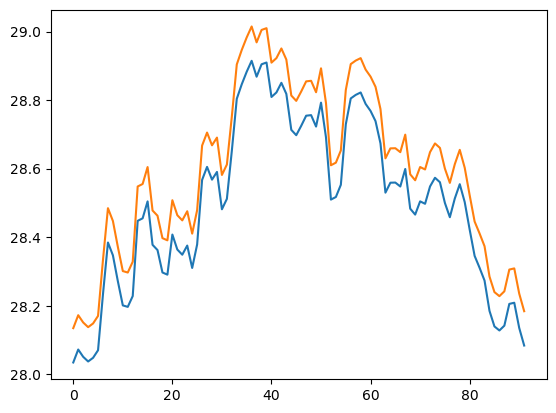

In [38]:
plt.plot(sst_.loc[str(y_story)])
plt.plot(a.loc[str(y_story)]+0.1)

In [57]:
forecast = pd.read_csv(f'../storylines/{y_now}-ACE-forecasts.csv', header=2)
forecast.head()

,Serial,SID,Submitted Time,Completed Time,Modified Time,Draft,IP Address,UID,Username,Short name,...,Category.3,ACE March-April Forecast,ACE March-April Low,ACE March-April High,ACE May-June Forecast,ACE May-June Low,ACE May-June High,ACE July-August Forecast,ACE July-August Low,ACE July-August High
0,tsr,0,07/12/2024 - 10:47,07/12/2024 - 10:47,07/12/2024 - 10:47,0,0,0,TSR,TSR,...,Accum. Cyclone Energy,217.0,NaN,NaN,226.0,NaN,NaN,240.0,NaN,NaN
1,canalytics,0,07/12/2024 - 09:09,07/12/2024 - 09:09,07/12/2024 - 09:09,0,0,0,CAnalytics,CAnalytics,...,Accum. Cyclone Energy,158.0,114.0,203.0,177.0,133.0,220.0,NaN,NaN,NaN
2,schlotthauer,0,07/12/2024 - 03:54,07/12/2024 - 03:54,07/12/2024 - 03:54,0,0,0,Schlotthauer,Schlotthauer,...,Accum. Cyclone Energy,NaN,NaN,NaN,210.0,NaN,NaN,275.0,255.0,295.0
3,nmme,0,07/9/2024 - 22:07,07/9/2024 - 22:07,07/9/2024 - 22:07,0,0,0,NMME,NMME,...,Accum. Cyclone Energy,229.2,206.9,251.4,NaN,NaN,NaN,190.5,169.2,211.8
4,csu,0,07/9/2024 - 16:50,07/9/2024 - 16:50,07/9/2024 - 16:50,0,0,0,CSU,CSU,...,Accum. Cyclone Energy,210.0,151.0,260.0,210.0,154.0,260.0,230.0,176.0,280.0


[Text(0, 2.5, 'July-August'),
 Text(0, 1.5, 'May-June'),
 Text(0, 0.5, 'March-April')]

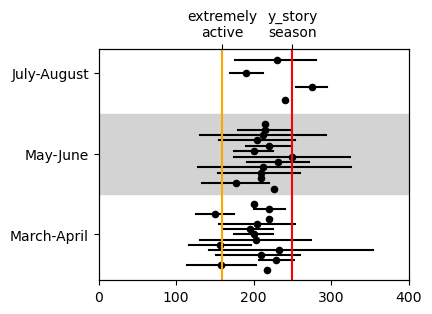

In [43]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(4,3), dpi=100, sharex=True)

ax.axhspan(1,2, color='lightgray')
ax.set_xlim(0,400)

periods = ['March-April', 'May-June', 'July-August']
for i,period in enumerate(periods):
    fs = forecast[f"ACE {period} Forecast"]
    names = forecast.loc[np.isfinite(fs), 'Username']
    step = 1/(len(names) + 2)
    for j,name in enumerate(names):
        if name == 'CAnalytics':
            color = 'k'
        else:
            color = 'k'
        l = forecast.loc[forecast['Username'] == name]
        ax.plot([l[f"ACE {period} Low"],l[f"ACE {period} High"]], [i+step+j*step]*2, color=color)
        ax.scatter(l[f"ACE {period} Forecast"], i+step+j*step, color=color, s=20)
    
ax.axvline(159.6, color='orange')
ax.axvline(250, color='red')

ax2 = ax.twiny()
ax2.set_xlim(0,400)
ax2.set_xticks([159.6, 250])
ax2.set_xticklabels(['extremely\nactive', 'y_story\nseason'])

ax.set_yticks([2.5,1.5,0.5])
ax.set_yticklabels(periods[::-1])

[Text(0, -2.5, 'March-April'),
 Text(0, -1.5, 'May-June'),
 Text(0, -0.5, 'July-August')]

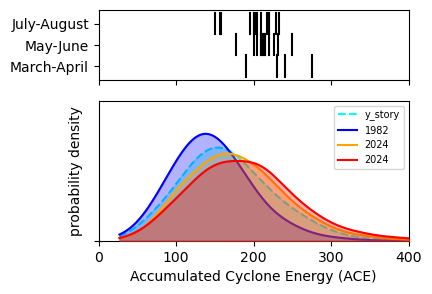

In [52]:
counterFacts['%s SST levels' %(y_story)].update({'color':'cyan', 'lsty':'--', 's':-0.0, 'label':"y_story"})
counterFacts['%s SST levels' %(y_now)].update({'color':'orange', 'lsty':'-', 's':0.3, 'label':y_now})
counterFacts['%s SST levels' %('1982')].update({'color':'blue', 'lsty':'-', 's':0.3, 'label':'1982'})
counterFacts['%s SST story' %(y_now)].update({'color':'red', 'lsty':'-', 's':0.3, 'label':y_now})

indicator = 'ACE'
threshold = 95

year_groups = {
    y_story : {'years':[y_story], 'color':'m', 'label':y_story, 'lsty':'-.', 'eva':0.4},
}

tmp = np.concatenate([d[indicator].values.flatten() for d in counterFacts.values()])
X = np.linspace(tmp.min(),tmp.max(),1000)
bw = (tmp.max() - tmp.min()) / 20

fig,axes = plt.subplots(nrows=2, ncols=1, figsize=(4,3), dpi=100, sharex=True, gridspec_kw=dict(height_ratios=[1,2]))

ax=axes[1]

for scen,DT in counterFacts.items():
    kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(DT[indicator].values.reshape(-1, 1))
    log_dens = kde.score_samples(X.reshape(-1, 1))
    pdf = np.exp(log_dens)# / np.exp(log_dens).sum()
    cdf = np.cumsum(pdf)
    ax.plot(X, pdf, color=DT['color'], linestyle=DT['lsty'], zorder=10)
    ax.fill_between(X, pdf, color=DT['color'], linestyle=DT['lsty'], alpha=0.3, zorder=10)

for scen,DT in counterFacts.items():
    DT = counterFacts[scen]
    ax.plot([],[], DT['color'], linestyle=DT['lsty'], label=DT['label'])

ax.set_xlabel('Accumulated Cyclone Energy (ACE)')
ax.set_xlim(0,400)
ax.annotate('observed\nin y_now', xy=(178, 0.02), color='gray', va='center',fontsize=8, 
        xycoords='data',xytext=(220, 0.02), textcoords='data',
        arrowprops=dict(arrowstyle= '-|>',
                        color='gray',lw=1.5,ls='-'))

ax.legend(fontsize=7, loc='upper right')
ax.set_ylabel('probability density')
ax.set_ylim(0,0.01)
ax.set_yticks([0])
ax.set_yticklabels([''])


periods = ['March-April', 'May-June', 'July-August']
for i,period in enumerate(periods):
    for f in forecast[f"ACE {period} Forecast"]:
        axes[0].plot([f]*2, [-i,-i-1], color='k')
axes[0].set_yticks([-2.5,-1.5,-0.5])
axes[0].set_yticklabels(periods)

#plt.savefig('../plots/storyline_y_story_in_y_now.png', 
#            bbox_inches='tight', transparent=True, dpi=400); plt.close()


#### Data for data wrapper

In [55]:
X = np.linspace(0,400,1000)
out = pd.DataFrame(index=X)
for scen,DT in counterFacts.items():
    kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(DT[indicator].values.reshape(-1, 1))
    log_dens = kde.score_samples(X.reshape(-1, 1))
    pdf = np.exp(log_dens)# / np.exp(log_dens).sum()
    cdf = np.cumsum(pdf)
    out[scen] = pdf
out.to_csv(f'../storylines/2024_2005_story_ACE.csv')

In [54]:
out

,2005 SST levels,1982 SST levels,2024 SST levels,2024 SST story
0.000000,0.000040,7.023979e-05,0.000026,0.000023
0.400400,0.000042,7.259818e-05,0.000027,0.000024
0.800801,0.000043,7.502087e-05,0.000028,0.000025
1.201201,0.000045,7.750914e-05,0.000029,0.000026
1.601602,0.000046,8.006429e-05,0.000030,0.000027
...,...,...,...,...
398.398398,0.000034,3.734693e-07,0.000085,0.000175
398.798799,0.000033,3.529936e-07,0.000084,0.000173
399.199199,0.000033,3.335416e-07,0.000083,0.000172
399.599600,0.000033,3.150681e-07,0.000082,0.000170


In [72]:
out = pd.DataFrame()
periods = ['May-June', 'July-August']
for i,period in enumerate(periods):
    fs = forecast[f"ACE {period} Forecast"]
    names = forecast.loc[np.isfinite(fs), 'Username']
    for j,name in enumerate(names):
        l = forecast.loc[forecast['Username'] == name]
        if np.isfinite(float(l[f"ACE {period} Low"])):
            out[f"{period} {name}"] = [float(l[f"ACE {period} Low"]), float(l[f"ACE {period} High"])]
out.to_csv(f'../storylines/forecasts.csv')

In [75]:
out

,May-June CAnalytics,May-June CSU,May-June 268Wx,May-June UArizona,May-June ECMWF,May-June AccuWeather,May-June WeatherTiger,May-June NOAA,May-June UKMO,May-June EarthNetworks,July-August Schlotthauer,July-August NMME,July-August CSU
0,133.0,154.0,128.0,191.0,175.0,175.0,190.0,155.0,131.0,180.0,255.0,169.2,176.0
1,220.0,260.0,326.0,271.0,324.0,225.0,250.0,253.0,293.0,250.0,295.0,211.8,280.0


In [74]:
l

,Serial,SID,Submitted Time,Completed Time,Modified Time,Draft,IP Address,UID,Username,Short name,...,Category.3,ACE March-April Forecast,ACE March-April Low,ACE March-April High,ACE May-June Forecast,ACE May-June Low,ACE May-June High,ACE July-August Forecast,ACE July-August Low,ACE July-August High
4,csu,0,07/9/2024 - 16:50,07/9/2024 - 16:50,07/9/2024 - 16:50,0,0,0,CSU,CSU,...,Accum. Cyclone Energy,210.0,151.0,260.0,210.0,154.0,260.0,230.0,176.0,280.0
